# Assignment 3 (100 pts) - Vector Space Models
---

In this assignment, you will learn about **vector space model**, and use python libraries such as **spacy**, **sklearn**, **gensim**, and **huggingface**, which are popular in NLP.

## Problem 1. Vector Space Models (65 pts)
---

The file: *will_play_text.csv* contains lines from William Shakespeare’s plays. The second column of the file contains the name of the play, while the fifth and the sixth contain the name of the character who spoke and what they spoke, respectively. **Tokenize** and **lower case** each line in *will_play_text.csv* using spacy. The file *vocab.txt* lists the words in the vocabulary, while the file *play_names.txt* lists the names of the plays. For the following questions, include generated visualizations in your answer sheet.

In [1]:
%%capture
%pip install sentence-transformers

In [2]:
import pandas as pd
import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations, product
from collections import defaultdict
import nltk
from gensim.models import Word2Vec
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

path = '/kaggle/input/cs505-hw3/'
nlp = spacy.load('en_core_web_sm')

Device: cuda


In [3]:
data = pd.read_csv(path + 'will_play_text.csv', delimiter=';', header=None)
data = data.drop(columns=[0, 2, 3])
data.columns = ['Play', 'Character', 'Text']
data = data.dropna()

df = data.sort_values(['Play', 'Text']).groupby('Play', sort=False)
df = df['Text'].apply(' '.join).reset_index(name='Text')

comedies = [
    'The Tempest', 'Two Gentlemen of Verona', 'Merry Wives of Windsor',
    'Measure for measure', 'A Comedy of Errors', 'Much Ado about nothing',
    'Loves Labours Lost', 'A Midsummer nights dream', 'Merchant of Venice',
    'As you like it', 'Taming of the Shrew', 'Alls well that ends well',
    'Twelfth Night', 'A Winters Tale', 'Pericles'
]
tragedies = [
    'Troilus and Cressida',
    'Coriolanus',
    'Titus Andronicus',
    'Romeo and Juliet',
    'Timon of Athens',
    'Julius Caesar',
    'macbeth',
    'Hamlet',
    'King Lear',
    'Othello',
    'Antony and Cleopatra',
    'Cymbeline',
]
histories = [
    'King John',
    'Richard II',
    'Henry IV',
    'Henry V',
    'Henry VI Part 1',
    'Henry VI Part 2',
    'Henry VI Part 3',
    'Richard III',
    'Henry VIII',
]

genres = []
for play in df['Play'].values:
    if play in comedies:
        genres.append('Comedy')
    elif play in tragedies:
        genres.append('Tradegy')
    else:
        genres.append('History')

df['Genre'] = genres

df['Text'] = df['Text'].apply(
    lambda x: ' '.join(x.lower() for x in str(x).split()))

df.head()

,Play,Text,Genre
0,A Comedy of Errors,"''tis dinner-time,' quoth i; 'my gold!' quoth ...",Comedy
1,A Midsummer nights dream,'a tedious brief scene of young pyramus 'littl...,Comedy
2,A Winters Tale,"'fore your queen died, she was more worth such...",Comedy
3,Alls well that ends well,"'after my flame lacks oil, to be the snuff 'bu...",Comedy
4,Antony and Cleopatra,'but yet' is as a gaoler to bring forth 'good ...,Tradegy


In [4]:
vocab = []
with open(path + 'vocab.txt') as f:
    for line in f:
        vocab.append(line.strip())

### 1. (5 pts) Create a term-document matrix where each row represents a word in the vocabulary and each column represents a play. Each entry in this matrix represents the number of times a particular word (defined by the row) occurs in a particular play (defined by the column). Use CountVectorizer in sklearn to create the matrix, using the file vocab.txt as input for the vocabulary parameter. From your term-document matrix, use PCA in sklearn to create a 2-dimensional representation of each play. Visualize these representations to see which plays are most similar to each other. Include the visualization in your answer sheet. You can follow the tutorial [here](https://machinelearningmastery.com/develop-word-embeddings-python-gensim/) to create the visualization.

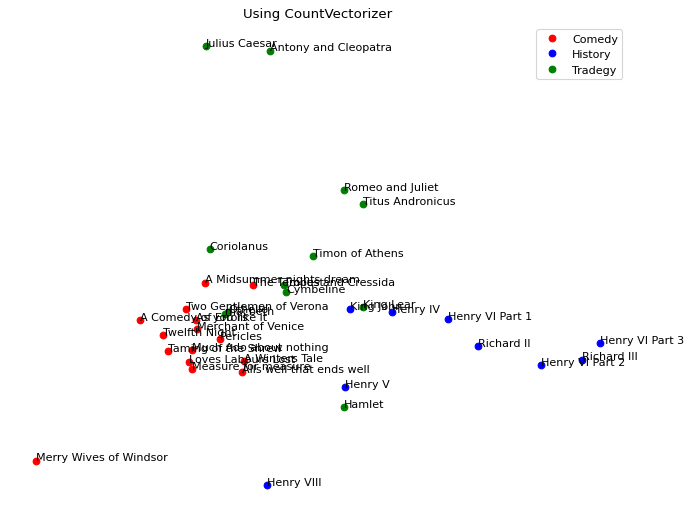

In [5]:
def showPlays(v):
    vectorizer = v(stop_words='english', vocabulary=vocab)
    vectors = vectorizer.fit_transform(df['Text'])

    matrix = pd.DataFrame(vectors.todense())
    matrix.columns = vectorizer.get_feature_names_out()
    matrix = matrix.T
    matrix.columns = df['Play'].values

    pca = PCA(n_components=2)
    term_doc_pca = pca.fit_transform(matrix.T)

    colours = {'Comedy': 'red', 'Tradegy': 'green', 'History': 'blue'}
    _ = plt.figure(figsize=(10, 8), dpi=80)
    groups = pd.DataFrame({
        'x': term_doc_pca[:, 0],
        'y': term_doc_pca[:, 1],
        'genre': df['Genre'].values
    }).groupby('genre')

    for genre, point in groups:
        plt.plot(point['x'],
                 point['y'],
                 marker='o',
                 linestyle='',
                 label=genre,
                 color=colours[genre])

    for i, word in enumerate(df['Play'].values):
        plt.annotate(word, xy=(term_doc_pca[i, 0], term_doc_pca[i, 1]))

    plt.title('Using ' + str(v.__name__))
    plt.axis('off')
    plt.legend()
    plt.show()


showPlays(CountVectorizer)

### 2. (2 pts) What plays are similar to each other? Do they match the grouping of Shakespeare’s plays into comedies, histories, and tragedies [here](https://en.wikipedia.org/wiki/Shakespeare%27s_plays#Canonical_plays)?

-> answer


### 3. (3 pts) Create another term-document matrix where each row represents a word in the vocabulary and each column represents a play, but with TFIDF counts (using TFIDFVectorizer in sklearn and vocab.txt for vocabulary). Use PCA again on these TFIDF term-document matrix and visualize the plays. Include the visualization in your answer sheet.

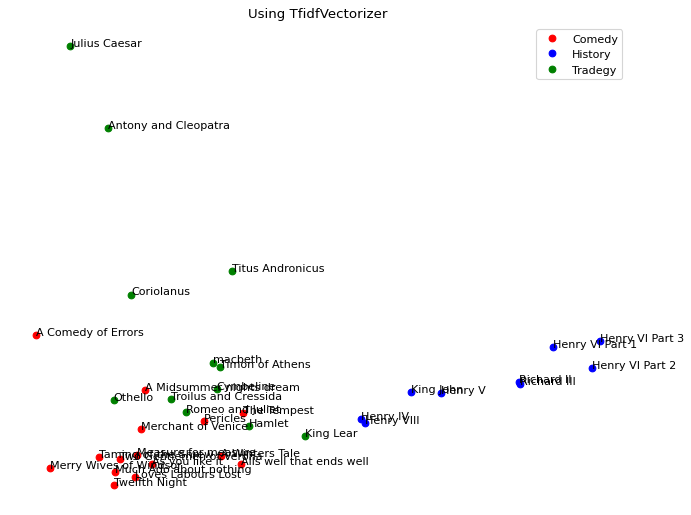

In [6]:
showPlays(TfidfVectorizer)

### 4. (2 pts) Does using TFIDF give you better grouping of plays? Why do you think so?

-> answer


### 5. (4 pts) Create a word-word matrix where each row (and each column) represents a word in the vocabulary (vocab.txt). Each entry in this matrix represents the number of times a particular word (defined by the row) co-occurs with another word (defined by the column) in a sentence (i.e., line in will play text.csv). Using the row word vectors, create a representation of a play as the average of all the word vectors in the play. Use these vector representations of plays to compute average pairwise cosine-similarity between plays that are comedies (do not include self-similarities). You can use the grouping of plays in [here](https://en.wikipedia.org/wiki/Shakespeare%27s_plays#Canonical_plays).

In [7]:
vectorizer = CountVectorizer(stop_words='english', vocabulary=vocab)

lines = []
for text in df['Text'].values:
    lines.append(text)
mat = vectorizer.fit_transform(lines)
mat.columns = vectorizer.get_feature_names_out()
mat = (mat.T * mat)
mat.setdiag(0)
mat = mat.toarray()

word_to_index = {word: i for i, word in enumerate(vocab)}
index_to_word = [word for _, word in enumerate(word_to_index)]
word_to_vector = {}
for i in range(mat.shape[0]):
    word_to_vector[index_to_word[i]] = mat[i]

/opt/conda/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [8]:
def tokenise(text):
    tokens = []
    for line in text:
        sent = nltk.word_tokenize(line)
        res = []
        for word in sent:
            if word in nlp.Defaults.stop_words:
                continue
            res.append(word.lower())
        tokens.append(res)
    return tokens


tokenised_lines = tokenise(df['Text'].values)

In [9]:
play_vectors = {}

for name, text, _ in zip(df['Play'].values, tokenised_lines,
                         tqdm(range(len(df['Play'].values)))):
    word_vectors = []
    for word in text:
        if word in word_to_index:
            word_vectors.append(word_to_vector[word])
    play_vectors[name] = np.mean(word_vectors, axis=0)

 97%|█████████▋| 35/36 [04:52<00:08,  8.34s/it]


In [10]:
def pairwiseCosSim(pairs):
    sim = []
    for (a, b) in pairs:
        v1 = play_vectors[a].reshape(1, -1)
        v2 = play_vectors[b].reshape(1, -1)
        sim.append(cosine_similarity(v1, v2))
    return np.mean(sim)


print('Comedies Cosine Similarity:',
      pairwiseCosSim(list(combinations(comedies, 2))))

Comedies Cosine Similarity: 0.999577076300042


### 6. (4 pts) Using vector representations of plays computed in (1.5), compute average pairwise cosine-similarity between plays that are histories, and between plays that are tragedies (do not include self-similarities).

In [11]:
print('Histories Cosine Similarity:',
      pairwiseCosSim(list(combinations(histories, 2))))

print('Tragedies Cosine Similarity:',
      pairwiseCosSim(list(combinations(tragedies, 2))))

Histories Cosine Similarity: 0.9995342401808434
Tragedies Cosine Similarity: 0.9996260582957834


### 7. (6 pts) Using vector representations of plays computed in (1.5), compute the average cosine-similarity between plays that are comedies and histories, the average cosine-similarity between plays that are comedies and tragedies, and the average cosine-similarity between plays that are histories and tragedies.

In [12]:
print('Comedies and Histories Cosine Similarity:',
      pairwiseCosSim(list(product(comedies, histories))))

print('Comedies and Tragedies Cosine Similarity:',
      pairwiseCosSim(list(product(comedies, tragedies))))

print('Histories and Tragedies Cosine Similarity:',
      pairwiseCosSim(list(product(histories, tragedies))))

Comedies and Histories Cosine Similarity: 0.9991429649063818
Comedies and Tragedies Cosine Similarity: 0.9995533457278226
Histories and Tragedies Cosine Similarity: 0.9993524015161556


### 8. (4 pts) Use gensim to learn 100-dimensional word2vec representation of the words in the play (you can use default parameters but with min count=1 so you can learn vector representations of all the words in your data i.e., no need to use vocab.txt in this question). Use the learned word2vec representation to construct vector representations of plays as the average of all the word vectors in the play. Use these vector representations of plays to compute average pairwise cosine-similarity between plays that are comedies (do not include self-similarities)

In [13]:
model = Word2Vec(sentences=tokenised_lines, min_count=1)

play_vectors = {}
for name, text in zip(df['Play'].values, tokenised_lines):
    word_vectors = []
    text = ' '.join(text)
    for word in text.lower().split():
        if word in model.wv:
            word_vectors.append(model.wv[word])
    play_vectors[name] = np.mean(word_vectors, axis=0)

print('Comedies Cosine Similarity:',
      pairwiseCosSim(list(combinations(comedies, 2))))

Comedies Cosine Similarity: 0.99900943


### 9. (4 pts) Using vector representations of plays computed in (1.8), compute average pairwise cosine-similarity between plays that are histories, and between plays that are tragedies (do not include self-similarities).

In [14]:
print('Histories Cosine Similarity:',
      pairwiseCosSim(list(combinations(histories, 2))))

print('Tragedies Cosine Similarity:',
      pairwiseCosSim(list(combinations(tragedies, 2))))

Histories Cosine Similarity: 0.99863464
Tragedies Cosine Similarity: 0.9991099


### 10. (6 pts) Using vector representations of plays computed in (1.8), compute the average cosine-similarity between plays that are comedies and histories, the average cosine-similarity between plays that are comedies and tragedies, and the average cosine-similarity between plays that are histories and tragedies.

In [15]:
print('Comedies and Histories Cosine Similarity:',
      pairwiseCosSim(list(product(comedies, histories))))

print('Comedies and Tragedies Cosine Similarity:',
      pairwiseCosSim(list(product(comedies, tragedies))))

print('Histories and Tragedies Cosine Similarity:',
      pairwiseCosSim(list(product(histories, tragedies))))

Comedies and Histories Cosine Similarity: 0.99821097
Comedies and Tragedies Cosine Similarity: 0.99888796
Histories and Tragedies Cosine Similarity: 0.9985235


### 11. (4 pts) For this question, use the original, non-tokenized, non-lowercased file. Use [LABSE](https://huggingface.co/sentence-transformers/LaBSE) in huggingface to compute vector representation of each line in will play text.csv. Unlike previous methods that compute word vectors, LABSE can compute whole line/sentence vectors. Compute the vector representation of each play as the average of its lines’ vector representations. Use these vector representations of plays to compute average pairwise cosine-similarity between plays that are comedies (do not include self-similarities)

In [16]:
%%capture
model = SentenceTransformer('sentence-transformers/LaBSE', device=device)

In [17]:
plays_to_lines = defaultdict(list)
for play, text in zip(data['Play'].values, data['Text'].values):
    plays_to_lines[play].append(text)

play_vectors = {}
for name, lines in plays_to_lines.items():
    line_vectors = model.encode(sentences=lines, show_progress_bar=False)
    play_vectors[name] = np.mean(line_vectors, axis=0)

In [18]:
print('Comedies Cosine Similarity:',
      pairwiseCosSim(list(combinations(comedies, 2))))


Comedies Cosine Similarity: 0.9517976


### 12. (4 pts) Using vector representations of plays computed in (1.11), compute average pairwise cosine-similarity between plays that are histories, and between plays that are tragedies (do not include self-similarities).

In [19]:
print('Histories Cosine Similarity:',
      pairwiseCosSim(list(combinations(histories, 2))))

print('Tragedies Cosine Similarity:',
      pairwiseCosSim(list(combinations(tragedies, 2))))


Histories Cosine Similarity: 0.96070164
Tragedies Cosine Similarity: 0.9570266


### 13. (6 pts) Using vector representations of plays computed in (1.11), compute the average cosine-similarity between plays that are comedies and histories, the average cosine-similarity between plays that are comedies and tragedies, and the average cosine-similarity between plays that are histories and tragedies.

In [20]:
print('Comedies and Histories Cosine Similarity:',
      pairwiseCosSim(list(product(comedies, histories))))

print('Comedies and Tragedies Cosine Similarity:',
      pairwiseCosSim(list(product(comedies, tragedies))))

print('Histories and Tragedies Cosine Similarity:',
      pairwiseCosSim(list(product(histories, tragedies))))

Comedies and Histories Cosine Similarity: 0.9230483
Comedies and Tragedies Cosine Similarity: 0.9456116
Histories and Tragedies Cosine Similarity: 0.9361833


### 14. (2 pts) Which vector representation (word-word counts vs. gensim vs. LABSE) gives the best measure of similarities between plays of similar genre vs. different genres? Why do you think so?

-> answer


### 15. (4pts)  Use LABSE’s vector representations of lines to construct the vector representation of each character as the average of all lines’ representations that the character spoke. Visualize the characters using PCA. Include the visualization in your answer sheet.

In [21]:
character_to_lines = defaultdict(list)
character_lines_number = defaultdict(int)

for character, text in zip(data['Character'].values, data['Text'].values):
    character_to_lines[character].append(text)

temp = {}
for character, text in character_to_lines.items():
    if len(text) > 600:
        temp[character] = text

character_to_lines = temp

In [22]:
%%capture
model = SentenceTransformer('sentence-transformers/LaBSE', device=device)

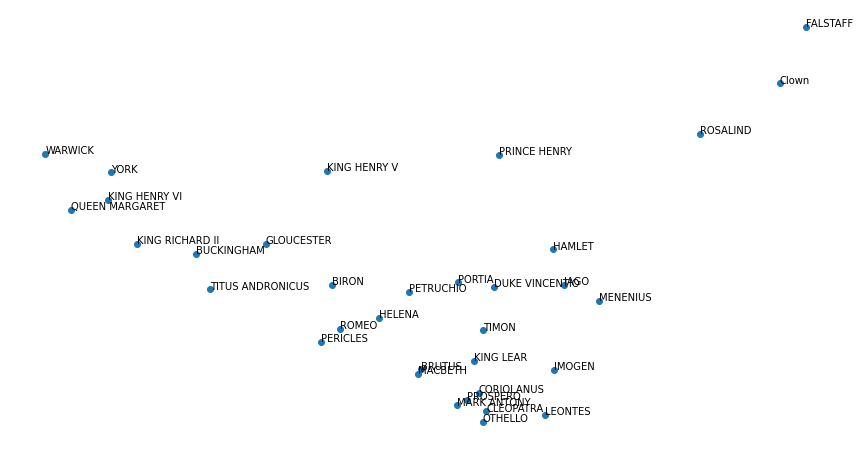

In [23]:
character_to_vectors = {}
for name, lines in character_to_lines.items():
    line_vectors = model.encode(sentences=lines, show_progress_bar=False)
    character_to_vectors[name] = np.mean(line_vectors, axis=0)

character_vectors = np.array(
    [vector for vector in character_to_vectors.values()])
pca = PCA(n_components=2)
character_vectors_pca = pca.fit_transform(character_vectors)

plt.figure(figsize=(15, 8))
plt.scatter(character_vectors_pca[:, 0], character_vectors_pca[:, 1])
for i, character in enumerate(character_to_vectors.keys()):
    plt.annotate(character,
                 xy=(character_vectors_pca[i, 0], character_vectors_pca[i, 1]))

plt.axis('off')
plt.show()

### 16. (5 pts) Mention 2 interesting insights with respect to the grouping of plays and/or characters e.g., what are characters that are most similar/dissimilar to each other? Do the vector representations of [female characters](https://en.wikipedia.org/wiki/Category:Female_Shakespearean_characters) differ distinguishably from [male ones](https://en.wikipedia.org/wiki/Category:Male_Shakespearean_characters)? Can you find plays that are central i.e., closest to centroid to each genre (i.e., comedies, histories, tragedies)? For each insight, include explanation and/or the visualization that supports your insight.


-> answer


## Problem 2. (35 pts)
---

In this question you will use the corpus of Shakespeare’s plays (*will_play_text.csv*) as well as two new corpora: the works of Jane Austen (*jane_austen.txt*) and Sir Arthur Conan Doyle (*arthur_conan doyle.txt*). For this question you will use **gensim** to create separate 100-dimensional word2vec word vector representations for each corpus. Then we will try to analyze the differences between these embeddings and try to understand what we can say about the bodies of work they were trained on.

In [24]:
import pandas as pd
from gensim.models import Word2Vec
from gensim.test.utils import datapath
import spacy
import nltk

nlp = spacy.load('en_core_web_sm')

In [25]:
data = pd.read_csv(path + 'will_play_text.csv', delimiter=';', header=None)
data = data.drop(columns=[0, 2, 3])
data.columns = ['Play', 'Character', 'Text']
shakespeareText = data['Text'].values

janeAustenText = []
with open(path + 'jane_austen.txt') as f:
    for line in f:
        janeAustenText.append(line.strip())

arthurConanDoyleText = []
with open(path + 'arthur_conan_doyle.txt') as f:
    for line in f:
        arthurConanDoyleText.append(line.strip())

### 1. (3 pts) Train word2vec representations for all three of the corpora (use min_count=1 to get vectors for all words in each processed corpus). Report the length of the vocabulary of each corpora. Be sure to clean and preprocess the text beforehand. Use **spacy** to sentence split, tokenize, lemmatize, lowercase, and remove stopwords.

In [26]:
def process(text):
    tokenised_lines = []
    for line in text:
        temp = []
        for word in nltk.word_tokenize(line):
            if word in nlp.Defaults.stop_words:
                continue
            temp.append(word.lower())
        tokenised_lines.append(temp)
    return tokenised_lines

In [27]:
shakespeareLines = process(shakespeareText)
janeAustenLines = process(janeAustenText)
arthurConanDoyleLines = process(arthurConanDoyleText)

In [28]:
shakespeareModel = Word2Vec(sentences=shakespeareLines, min_count=1)
print('Length of Shakespeare vocab size:', len(shakespeareModel.wv))

janeAustenModel = Word2Vec(sentences=janeAustenLines, min_count=1)
print('Length of Jane Austen vocab size:', len(janeAustenModel.wv))

arthurConanDoyleModel = Word2Vec(sentences=arthurConanDoyleLines, min_count=1)
print('Length of Arthur Conan Doyle vocab size:',
      len(arthurConanDoyleModel.wv))


Length of Shakespeare vocab size: 25958
Length of Jane Austen vocab size: 16633
Length of Arthur Conan Doyle vocab size: 38659


### 2. (6 pts) Once you have the word2vec models, report the closest 3 words (using cosine-similarity) to each of these words in the list for each of the three corpora. The word list is: ['courage', 'hope', 'love', 'woman', 'man', 'he', 'she', 'good', 'bad', 'evil', 'beauty', 'fate'].

In [29]:
word_list = [
    'courage', 'hope', 'love', 'woman', 'man', 'he', 'she', 'good', 'bad',
    'evil', 'beauty', 'fate'
]


def closestWords(model, topK=3):
    sim = {}
    for word in word_list:
        sim[word] = [word for word, _ in model.wv.similar_by_word(word)[:topK]]

    return sim


print('Shakespeare closest words:\n', closestWords(shakespeareModel))
print('\nJane Austen closest words:\n', closestWords(janeAustenModel))
print('\nArthur Conan Doyle closest words:\n',
      closestWords(arthurConanDoyleModel))


Shakespeare closest words:
 {'courage': ['condition', 'stands', 'rich'], 'hope': ['warrant', 'thought', 'wish'], 'love': ['life', 'honour', 'fear'], 'woman': ['honest', 'fellow', 'thing'], 'man': ['woman', 'fellow', 'old'], 'he': ['it', 'your', 'she'], 'she': ['not', 'most', 'have'], 'good': ['gentle', 'noble', 'sweet'], 'bad': ['joyful', 'earnest', 'deserved'], 'evil': ['physic', 'proved', 'virtues'], 'beauty': ['rich', 'virtue', 'sense'], 'fate': ['bones', 'pride', 'parts']}

Jane Austen closest words:
 {'courage': ['receive', 'desired', 'autumn'], 'hope': ['afraid', 'sorry', 'dare'], 'love': ['like', 'pretty', 'girl'], 'woman': ['man', 'men', 'people'], 'man': ['woman', 'men', 'people'], 'he': ['she', 'they', 'there'], 'she': ['he', 'they', 'in'], 'good': ['great', 'vast', 'love'], 'bad': ['happen', 'pity', 'fault'], 'evil': ['fact', 'enjoy', 'separation'], 'beauty': ['address', 'acknowledged', 'struck'], 'fate': ['gown', 'weymouth', 'rain']}

Arthur Conan Doyle closest words:
 {'co

### 3. (3 pts) Add another three words that you think would be interesting to observe over the different corpora. Report the closest 3 words (using cosine-similarity) to each of your chosen words for each of the three authors.

In [30]:
word_list = ['kill', 'love', 'hate']

print('Shakespeare closest words:\n', closestWords(shakespeareModel))
print('Jane Austen closest words:\n', closestWords(janeAustenModel))
print('Arthur Conan Doyle closest words:\n',
      closestWords(arthurConanDoyleModel))

Shakespeare closest words:
 {'kill': ['live', 'ask', 'lie'], 'love': ['life', 'honour', 'fear'], 'hate': ['prove', 'bear', 'sworn']}
Jane Austen closest words:
 {'kill': ['fit', 'gives', 'behave'], 'love': ['like', 'pretty', 'girl'], 'hate': ['bear', 'trust', 'presume']}
Arthur Conan Doyle closest words:
 {'kill': ['pay', 'play', 'honor'], 'love': ['bad', 'true', 'jack'], 'hate': ['ride', 'anxious', 'ashamed']}


### 4. (2 pts) Mention any differences between the close words across different documents. What do you think the difference indicates? For example, does the difference represent any gender bias?

-> answer


### 5. (15 pts) Look into this [repository](https://github.com/nicholas-leonard/word2vec/blob/master/questions-words.txt). This file provides a list of analogies. Analogies are essentially meaning symmetries in language. They can be direct analogies like Paris France Berlin Germany. Here we know that what Paris is to France, The same thing Berlin is to Germany. Some earlier work has showed that this relationship sometimes is also captured in word representations. Imagine the relationship to be: $$ \text{w(paris) - w(france) == w(berlin) - w(germany) (1)} $$ Then the below relationship also holds: $$ \text{w(paris) - w(france) + w(germany) == w(berlin) (2)} $$ This makes sense on paper but in practice the representation relationships are not always this clear. Instead we calculate the left side of the equation and check the closest word (in terms of cosine-similarity) in the vocabulary to the calculated embedding. If the word is the one on the right we say that the analogy holds. So what we want you to do is read all the analogies in the given link and for each author, remove any analogies that have OOV words. Don’t try to find analogies that hold for all three authors. For each of the three authors, remove OOV analogies and from the ones that are left (i.e., don’t include any OOV words), we want you to check how many of the analogies hold (i.e., calculate the accuracy). Report the analogy accuracy of each author.

In [31]:
score, sections = shakespeareModel.wv.evaluate_word_analogies(
    analogies=datapath('questions-words.txt'))
print('Shakespeare score: {}%'.format(round(score * 100, 4)))

score, sections = janeAustenModel.wv.evaluate_word_analogies(
    analogies=datapath('questions-words.txt'), )
print('Jane Austen score: {}%'.format(round(score * 100, 4)))

score, sections = arthurConanDoyleModel.wv.evaluate_word_analogies(
    analogies=datapath('questions-words.txt'))
print('Arthur Conan Doyle score: {}%'.format(round(score * 100, 4)))

Shakespeare score: 0.3613%
Jane Austen score: 1.528%
Arthur Conan Doyle score: 0.8374%


### 6. (6 pts) What does the accuracy scores tell you? Which corpus then gives you better commonsense representations? Do you think this is a good way to measure word representations e.g., can you think of potential issues in designing analogies?

-> answer
